In [224]:
using MatrixProductBP, MatrixProductBP.Models
using Distributions, Statistics, Base.Threads, Plots
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [225]:
T = 25
c = 3
m⁰ = -0.4

β = 1.0
J = 3.0
h = 0.0;

In [226]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
ψ_neutral = [ones(2,2) for t in 0:T];

In [227]:
popsize = 10^2
P = map(1:popsize) do _
    μ = rand_mpem2(2, 2, T)
    normalize!(μ)
    μ
end
nsamples = 10^2
degree_prob = truncated(Poisson(c), 0, popsize)
maxiter = 5*10^1
svd_trunc = TruncBond(10);

In [228]:
function onebpiter_inner(μ, wᵢ, dᵢ, ns, ϕ, ψ, T, svd_trunc)
    C, full, logzᵢ = MatrixProductBP.Models.compute_prob_ys(wᵢ, ns, μ, ψ, T, svd_trunc)
    for j in 1:dᵢ
        B = MatrixProductBP.Models.f_bp_partial_ij(C[j], wᵢ, ϕᵢ, dᵢ - 1, ns)
        μ[j] = sweep_RtoL!(mpem2(B); svd_trunc)
        logzᵢ += normalize!(μ[j])
    end
    B = MatrixProductBP.Models.f_bp_partial_i(full, wᵢ, ϕᵢ, dᵢ)
    b = B |> mpem2 |> marginalize
    f = dᵢ == 0 ? 0.0 : -logzᵢ / dᵢ
    return μ, b, f
end

onebpiter_inner (generic function with 1 method)

In [ ]:
bs = [[[zeros(2) for _ in 0:T] for _ in 1:nsamples] for _ in 1:maxiter]
@showprogress for it in 1:maxiter
    for n in 1:nsamples
        d = rand(degree_prob)
        indices = rand(1:popsize, d)     
        μ, b, f = onebpiter_inner(P[indices], wᵢ, d, 2, ϕᵢ, fill(ψ_neutral, d), T, svd_trunc)
        P[indices] = μ
        bs[it][n] .= marginals(b)
    end
end

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:10:32

In [ ]:
m_avg = mean([[bb[1]-bb[2] for bb in b] for b in bs[end]])
m_std = std([[bb[1]-bb[2] for bb in b] for b in bs[end]]) ./ sqrt(nsamples);

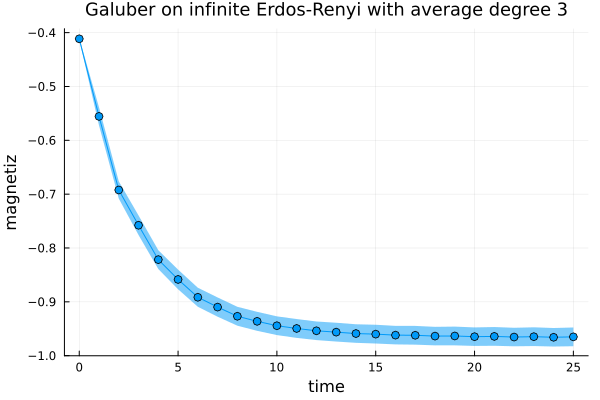

In [236]:
plot(0:T, m_avg, m=:o, ribbon=m_std, label="", xlabel="time", ylabel="magnetiz",
    title="Galuber on infinite Erdos-Renyi with average degree $c", titlefontsize=12)